We've gone a little far and it's about time to review things — I will be checking on Tutorial Tasks (previous weeks) and answer your questions.



```
Please note that there's implementation and tuning of methods you haven't yet learnt, like Logistic Regression and Support Vector Machines (SVC or SVM) though you can keep them in your experiment as we're covering them later on, or for the time being tune and optimise models you learnt in their place; random forest, kNN, decision trees and bagging. 

```



Today's (Week 8) extra is on Cross Validation and Model Selection. 

# Example **A**: Ensemble Classifier 


Example from Sklearn Documentation on **Ensemble Classifier** (`VotingClassifier`) which compares standalone classifiers:

Decision Tree, Knn, SVC (you can expand to include further classifiers). The example also shows class boundary per each different classifier. 

Note that there's no cross validation here — evaluation is done on the whole dataset (this is just to show the *VotingClassifier*)











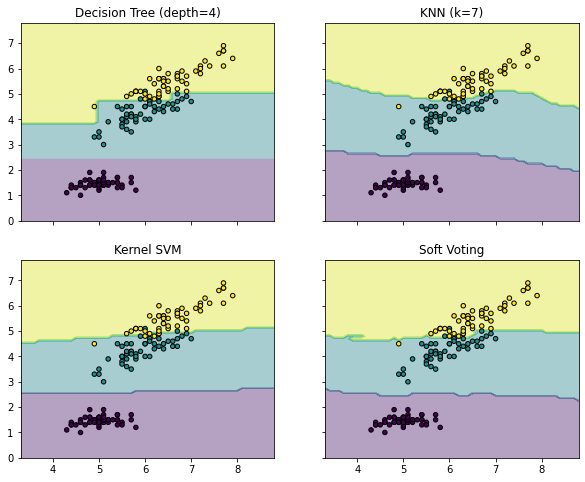

In [ ]:

from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training classifiers - say, your candidates
# Note that you now are including the VotingClassifier which takes the three candidates as input, and corresponding voting weights (equal weights if not specified).
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(gamma=.1, kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='hard', weights=[2, 5, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

---


## Tasks **A** ##


*   Include Random Forest Classifier in your pool of classifiers, draw classifcantion boundary for each.

*   *Soft voting* is applied — with weights being **2**, **1** and **2** for the three classifiers. Change weights and observe decision boundary (for instance, if you add more weight to Knn, you should see decision boundary move similar to Knn decision boundary).

*   *Soft voting* is applied — apply hard voting instead (`voting='hard'`) and observe decision boundary change. 



---


# Example  **B**: Cross Validation and Model Selection

Adapted from Sklearn Documentation — **VotingClassifier** & **Cross Validation**:

Aim: This is a working example on Cross Validation — evaluating candidate learners (classifiers) is conducted as shown in the example:
**Dataset**: randomly created. 

The general procedure in cross validation is as follows:

*   Shuffle the dataset randomly.
*> For each unique group:
  1.   Take the group as a hold out or test data set
  2.   Take the remaining groups as a training data set
  3.   Fit a model on the training set and evaluate it on the test set
  4.   Retain the evaluation score and discard the model

*   Summarise the skill of the model using the sample of model evaluation scores













>DT 0.758 (0.049)
>Knn 0.899 (0.035)
>svm1 0.737 (0.051)
>svm2 0.855 (0.035)
>RF 0.889 (0.029)
>soft_voting 0.898 (0.034)


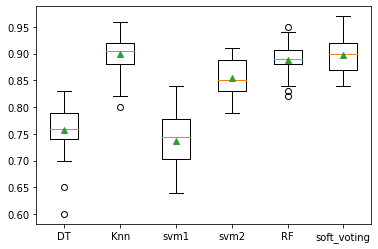

In [ ]:

# compare soft voting ensemble to standalone classifiers
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot
 
# get the dataset - this is a synthetic dataset. 
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=2)
	return X, y
 
# get a voting ensemble of models. {please note models here are hypertuned at random — no nested cross validation applied. The assumption that it's a process that has been done earlier.} 
def get_voting():
	# define the base models
	models = list()
	models.append(('DT', DecisionTreeClassifier(max_depth=4)))
	models.append(('Knn', KNeighborsClassifier(n_neighbors=7)))
	models.append(('svm1', SVC(gamma=.1, kernel='rbf', probability=True)))
	models.append(('svm2', SVC(probability=True, kernel='poly', degree=1)))
	models.append(('RF', RandomForestClassifier(n_estimators=100)))
	# define the voting ensemble
	ensemble = VotingClassifier(estimators=models, voting='soft', weights=[1, 2, 1, 1, 2])
	return ensemble
 
# get a list of models to evaluate
def get_models():
	models = dict()
	models['DT'] = DecisionTreeClassifier(max_depth=4)
	models['Knn'] = KNeighborsClassifier(n_neighbors=7)
	models['svm1'] = SVC(gamma=.1, kernel='rbf', probability=True)
	models['svm2'] = SVC(probability=True, kernel='poly', degree=1)
	models['RF'] = RandomForestClassifier(n_estimators=100)

	models['soft_voting'] = get_voting()
	return models
 
# evaluate a give model using cross-validation. 
# Note that evaluation is done with a stratified cross validation (and repeated, 3 times here). 
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, error_score='raise')
	return scores
 
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()




## Tasks **B** ##

---


1.   Apply cross validation (change dataset in the code above) on Breast Cancer Dataset and report models' accuracy. Which candidate model is your best performing model?

2.   ***Soft voting*** is applied — tune weights on the basis of performance rank, and report pefrorance result of your voting classifier. 

3.   ***Soft voting*** is applied — apply hard voting instead (`voting='hard'`) and report peformance resuslts.  

4. Include Logistic Regression Classifier and report results.

4.   Note that `RepeatedStratifiedKFold` (which repeats Stratified K-Fold *n* times with different randomization in each repetition) is applied - read more on the moethod [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html). Now apply the Kfold cross validation instead — imported as `from sklearn.model_selection import KFold` with same nubmer of splits (folds) and compare resulsts with the RepeatedStratified validation - as `KFold(n_splits=10, shuffle=True, random_state=1)`

---

# Example  **D**: Nested Cross Validation and Model Selection



Aim: This is a working example on Nested Cross Validation — evaluating a learner (Random Forest) is conducted as shown in the example:

**Dataset**: Iris dataset. 

The general procedure in cross validation is as follows: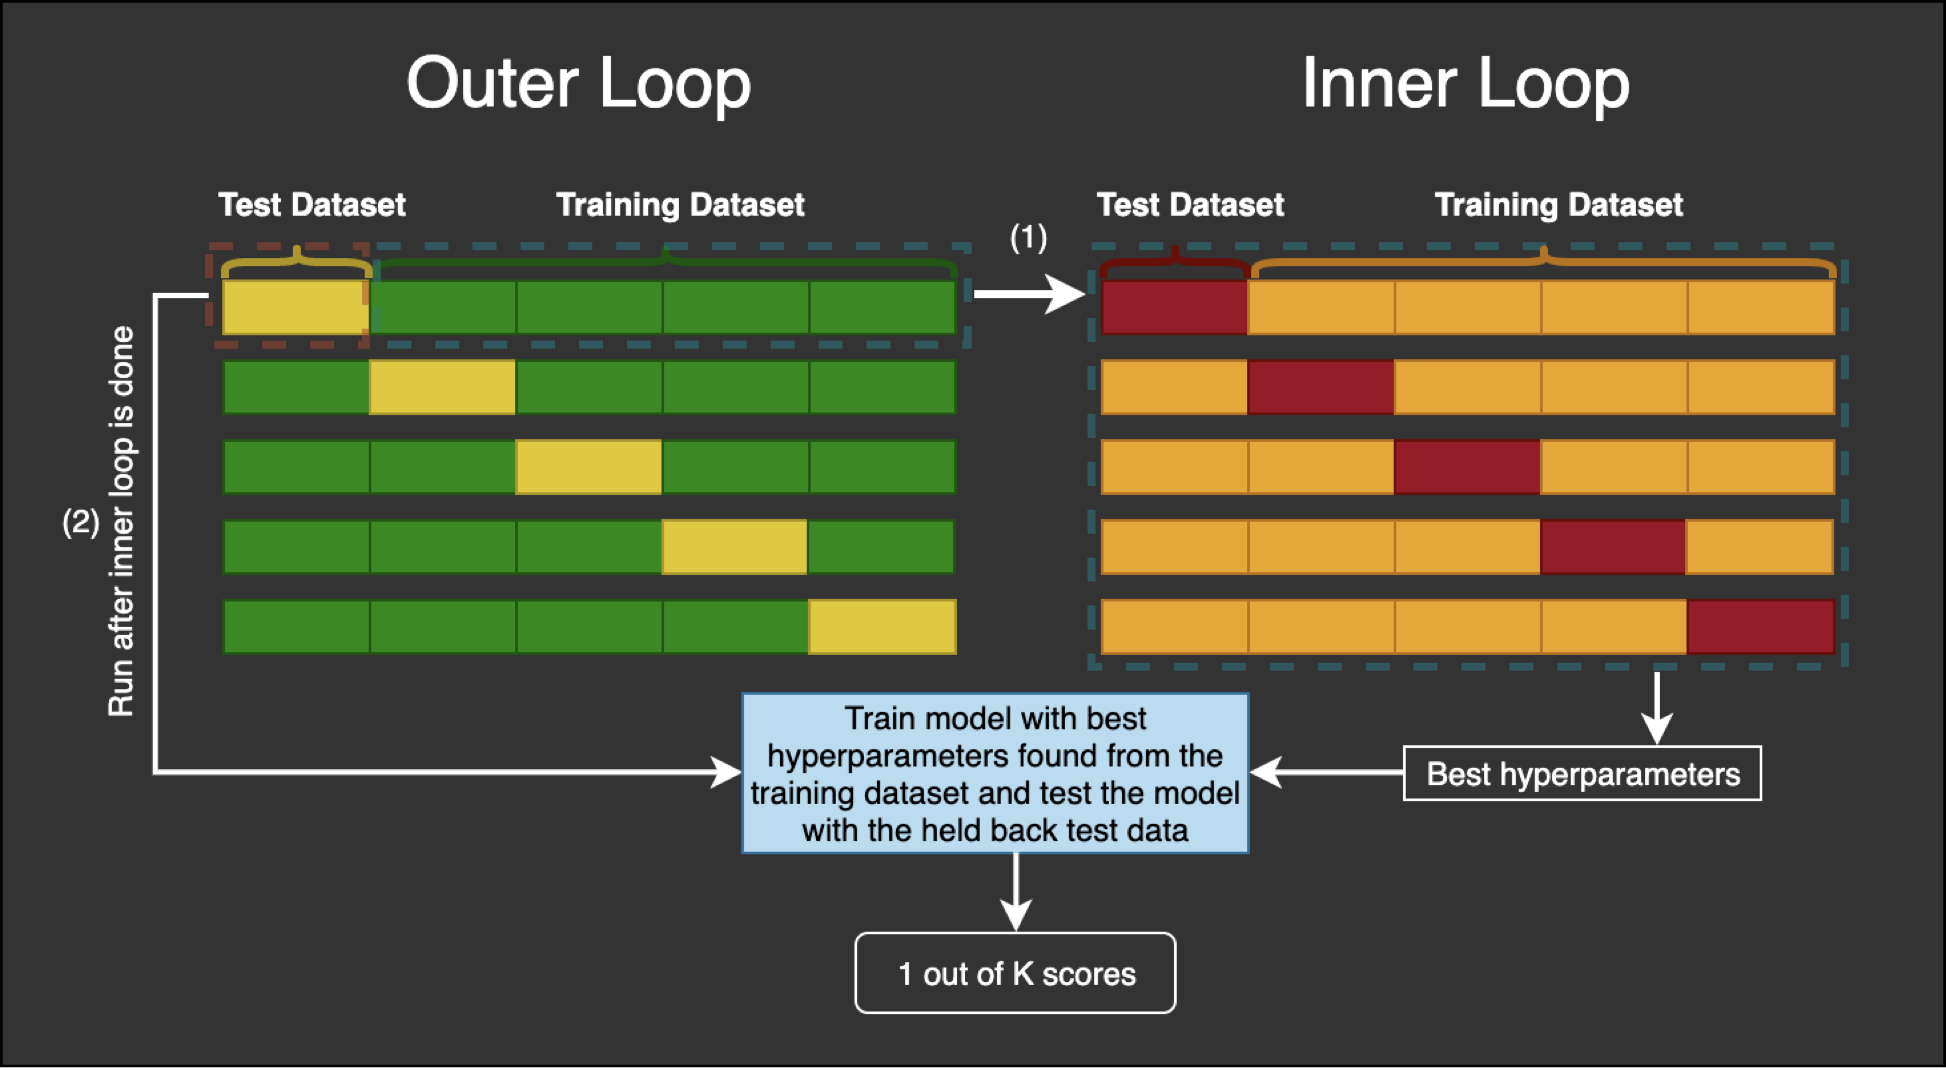





This is a nested cross validation of 10 outer folds, and 3 inner folds for each.Final model is generated through both loops — model skill becomes the mean of cross validation score. You also can print model parameters for best peforming Random Forest (provided in the example below). 

In [ ]:
# automatic nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# create dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=1, n_informative=10, n_redundant=10)
# configure the cross-validation procedure
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
# define the model
model = RandomForestClassifier(random_state=1)
# define search space (parms for hyperparameters, sometimes you find it as param_grid or simply parameters)

params = dict()
params['n_estimators'] = [2, 4, 10]
params['max_features'] = [2, 4, 6]
# define the classfier as one whose hyperparameters are found/optimised via GridSearchCV. 
clf = GridSearchCV(model, params, scoring='accuracy', cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# execute the nested cross-validation
# note that clf (the classifier) is fit is tuned earlier on the nested (cv_inner) and evaluated on the outer cv.
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv_outer)
print('Each Fold score (we have 10 here): %s' % scores)


# report performance - this is what you report as your model. 
print('Model Accuracy (mean. This is your estimation of model accuracy): %.3f (%.3f)' % (mean(scores), std(scores)))




# If you want to see the parameters which were found for the 'best performing' model, fit the (GridSearched) model and print its parameters as follows:
clf.fit(X,y)
# Best params
print('Model Best params: %s' % clf.best_params_)
# Best training data accuracy - uncomment below if you want.
#print('Model Best training accuracy: %.3f' % clf.best_score_)

Each Fold score (we have 10 here): [0.87 0.92 0.9  0.9  0.91 0.87 0.92 0.92 0.92 0.88]
Model Accuracy (mean. This is your estimation of model accuracy): 0.901 (0.020)
Model Best params: {'max_features': 4, 'n_estimators': 10}



## Tasks **D** ##

---


1. Apply the above procedure on another classfier and tune and print best parameters of your choice (SVC, Logistic Regression, Knn, Decision Tree).
2. Can you implement a battery of evaluations for a set of models instead of just one?



---
This is extra.

# Back to Back Modelling     
 

---

No Tasks — applying much of what you learnt thus far to tune models, and pick one (learn also, if you like, the use of pipelines). 
— source [here](https://www.kdnuggets.com/2018/01/managing-machine-learning-workflows-scikit-learn-pipelines-part-3.html)

`Note 1`: PCA will be covered in coming weeks (don't worry if you haven't used it before).

`Note 2`: This will take long time to run — you can reduce the battery of models to two if you want faster results. 




In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# Load and split the data
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()),
			('clf', LogisticRegression(random_state=42))])

pipe_lr_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', LogisticRegression(random_state=42))])

pipe_rf = Pipeline([('scl', StandardScaler()),
			('clf', RandomForestClassifier(random_state=42))])

pipe_rf_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', RandomForestClassifier(random_state=42))])

pipe_svm = Pipeline([('scl', StandardScaler()),
			('clf', svm.SVC(random_state=42))])

pipe_svm_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', svm.SVC(random_state=42))])
			
# Set grid search params
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
		'clf__C': param_range_fl,
		'clf__solver': ['liblinear']}] 

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
		'clf__min_samples_leaf': param_range,
		'clf__max_depth': param_range,
		'clf__min_samples_split': param_range[1:]}]

grid_params_svm = [{'clf__kernel': ['linear', 'rbf'], 
		'clf__C': param_range}]

# Construct grid searches
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr,
			param_grid=grid_params_lr,
			scoring='accuracy',
			cv=10) 
			
gs_lr_pca = GridSearchCV(estimator=pipe_lr_pca,
			param_grid=grid_params_lr,
			scoring='accuracy',
			cv=10)
			
gs_rf = GridSearchCV(estimator=pipe_rf,
			param_grid=grid_params_rf,
			scoring='accuracy',
			cv=10, 
			n_jobs=jobs)

gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
			param_grid=grid_params_rf,
			scoring='accuracy',
			cv=10, 
			n_jobs=jobs)

gs_svm = GridSearchCV(estimator=pipe_svm,
			param_grid=grid_params_svm,
			scoring='accuracy',
			cv=10,
			n_jobs=jobs)

gs_svm_pca = GridSearchCV(estimator=pipe_svm_pca,
			param_grid=grid_params_svm,
			scoring='accuracy',
			cv=10,
			n_jobs=jobs)

# List of pipelines for ease of iteration
grids = [gs_lr, gs_lr_pca, gs_rf, gs_rf_pca, gs_svm, gs_svm_pca]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Logistic Regression w/PCA', 
		2: 'Random Forest', 3: 'Random Forest w/PCA', 
		4: 'Support Vector Machine', 5: 'Support Vector Machine w/PCA'}

# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
	print('\nEstimator: %s' % grid_dict[idx])	
	# Fit grid search	
	gs.fit(X_train, y_train)
	# Best params
	print('Best params: %s' % gs.best_params_)
	# Best training data accuracy
	print('Best training accuracy: %.3f' % gs.best_score_)
	# Predict on test data with best params
	y_pred = gs.predict(X_test)
	# Test data accuracy of model with best params
	print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
	# Track best (highest test accuracy) model
	if accuracy_score(y_test, y_pred) > best_acc:
		best_acc = accuracy_score(y_test, y_pred)
		best_gs = gs
		best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

# Save best grid search pipeline to file
dump_file = 'best_gs_pipeline.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: Logistic Regression
Best params: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.917
Test set accuracy score for best params: 0.967 

Estimator: Logistic Regression w/PCA
Best params: {'clf__C': 0.5, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.858
Test set accuracy score for best params: 0.933 

Estimator: Random Forest


KeyboardInterrupt: ignored